In [1]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pixel as pix
import utilities as util
import tile
import importlib
importlib.reload(tile)

<module 'tile' from '/host/Desktop/cnn_dev/florence_mapping/tile.py'>

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [3]:
landsat, sentinel, dem, label = util.load_data()
tile_size = 64
num_classes = util.get_class_count()
pixel_gen = pix.pixel_gen(landsat, sentinel, dem, label, tile_size, num_classes)
tile_gen = tile.tile_gen(landsat, sentinel, dem, label, tile_size, num_classes)

In [4]:
pixels = pixel_gen.gen_pixels(60000, index = 1, balanced=True)

pixels generated 47197


In [5]:
train_px, val_px, test_px = pixel_gen.train_val_test_split(pixels, 0.7, 0.7)
pixel_gen.print_balance()

train:33037 val:9912 test:7222
Water:2197.0
Snow/Ice:0.0
Open Space Developed:3750.0
Low Intensity Developed:0.0
Medium Intensity Developed:3750.0
High Intensity Developed:0.0
Barren Land:3750.0
Deciduous Forest:3750.0
Evergreen Forest:3750.0
Mixed Forest:3750.0
Scrub/Shrub:3750.0
Grassland / Herbaceous:3750.0
Pasture/Hay:3750.0
Cultivated Land:3750.0
Woody Wetland:3750.0
Emergent Herbaceous Wetlands:3750.0


In [6]:
import resnet as rs
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
epochs = 20
batch_size = 25
input_shape = tile_gen.get_tile_shape(reshape=True)
print(input_shape)

(10, 64, 64)


In [8]:
model = rs.ResnetBuilder.build_resnet_18(input_shape, num_classes)
opt = Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/20
1321/1321 [==============================] - 169s 128ms/step - loss: 2.3392 - acc: 0.3715 - val_loss: 2.1661 - val_acc: 0.3800
Epoch 2/20
1321/1321 [==============================] - 163s 123ms/step - loss: 1.8926 - acc: 0.4360 - val_loss: 1.9463 - val_acc: 0.4033
Epoch 3/20
1321/1321 [==============================] - 162s 123ms/step - loss: 1.7543 - acc: 0.4647 - val_loss: 1.8456 - val_acc: 0.4350
Epoch 4/20
1321/1321 [==============================] - 162s 123ms/step - loss: 1.6639 - acc: 0.4920 - val_loss: 1.8887 - val_acc: 0.4212
Epoch 5/20
1321/1321 [==============================] - 161s 122ms/step - loss: 1.5914 - acc: 0.5150 - val_loss: 1.8657 - val_acc: 0.4365
Epoch 6/20
1321/1321 [==============================] - 162s 123ms/step - loss: 1.5246 - acc: 0.5394 - val_loss: 1.8813 - val_acc: 0.4419
Epoch 7/20
1321/1321 [==============================] - 164s 124ms/step - loss: 1.4659 - acc: 0.5571 - val_loss: 1.9304 - val_acc: 0.4333
Epoch 8/20
1321/1321 [============

154/154 [==============================] - 40s 260ms/step
Accuracy is 0.45150162337662336


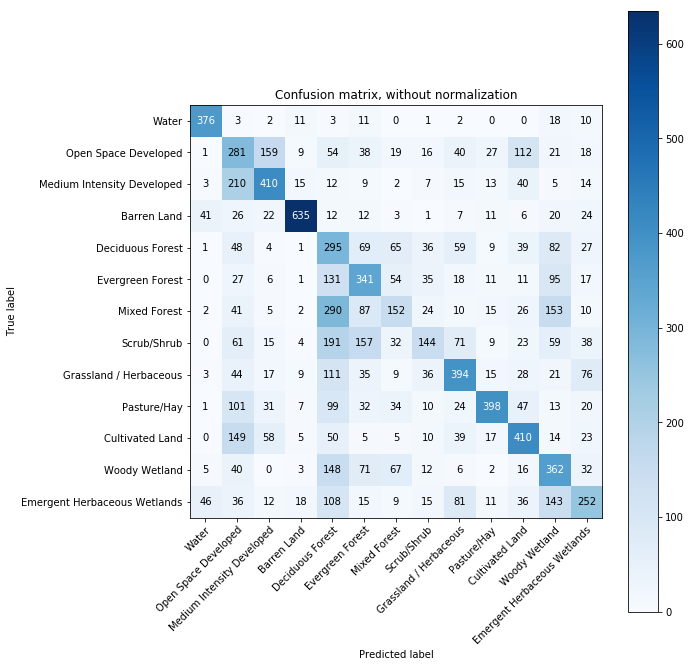

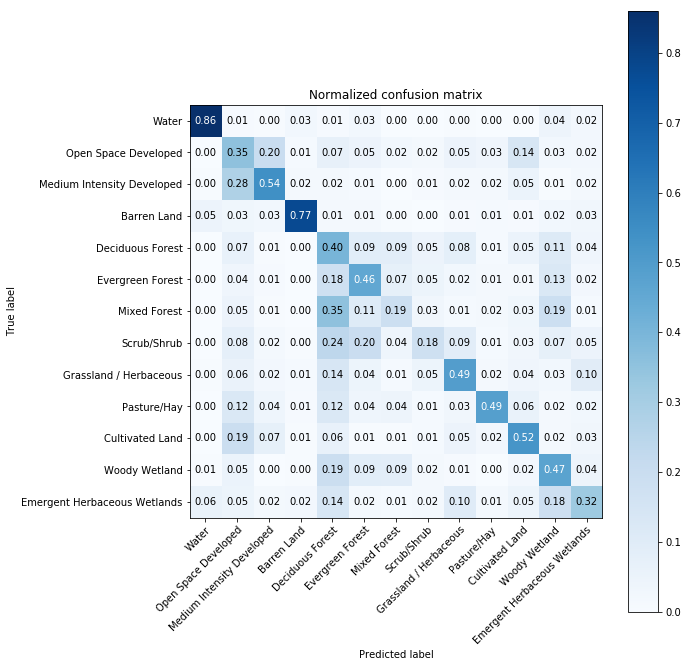

In [10]:
tile_gen.evaluate_cnn(model, test_px)